Drugs Reviews Dataset:
    
We will be using this open source dataset made available by UCI machine learning library to perform EDA and sentiment analysis. We will use NLP and Deep Learning to make a sentiment prediction model using the text review data.

In [1]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
import nltk
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
import random
import collections
%matplotlib inline
from plotly import tools
import plotly.graph_objects as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV 
from time import time

Using TensorFlow backend.


In [2]:
#readint the .csv files
train_data = pd.read_csv("drugsComTrain_raw.csv")  
test_data = pd.read_csv("drugsComTest_raw.csv")

In [3]:
train_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
train_data['review'][4]

'"Suboxone has completely turned my life around.  I feel healthier, I&#039;m excelling at my job and I always have money in my pocket and my savings account.  I had none of those before Suboxone and spent years abusing oxycontin.  My paycheck was already spent by the time I got it and I started resorting to scheming and stealing to fund my addiction.  All that is history.  If you&#039;re ready to stop, there&#039;s a good chance that suboxone will put you on the path of great life again.  I have found the side-effects to be minimal compared to oxycontin.  I&#039;m actually sleeping better.   Slight constipation is about it for me.  It truly is amazing. The cost pales in comparison to what I spent on oxycontin."'

ANALYSIS OF THE GIVEN DATA

In [5]:
print("Shape of the training data is: ", train_data.shape) 
print("Shape of the testing data is: ", test_data.shape)

Shape of the training data is:  (161297, 7)
Shape of the testing data is:  (53766, 7)


In [6]:
#number of unique conditions in training and testing data
x = train_data['condition'].nunique()
print("There are total",x,"unique conditions training data")
x = test_data['condition'].nunique()
print("There are total",x,"unique conditions testing data")

There are total 884 unique conditions training data
There are total 708 unique conditions testing data


Text(0.5, 1.0, 'Drugs per condition in given training data')

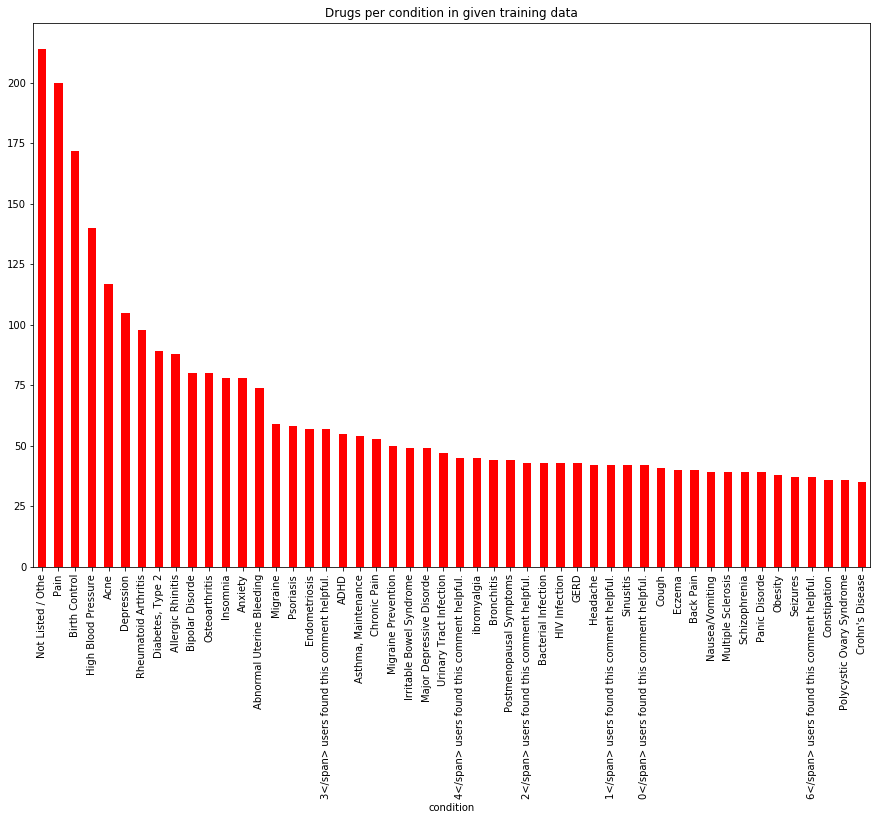

In [7]:
#bar graph representing the drugs that are available for each condition for both training and testing data
condition_drugName_train = train_data.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_drugName_train[0:50].plot(kind="bar", figsize = (15,10), color="red")
plt.title("Drugs per condition in given training data")

Text(0.5, 1.0, 'Drugs per condition in given testing data')

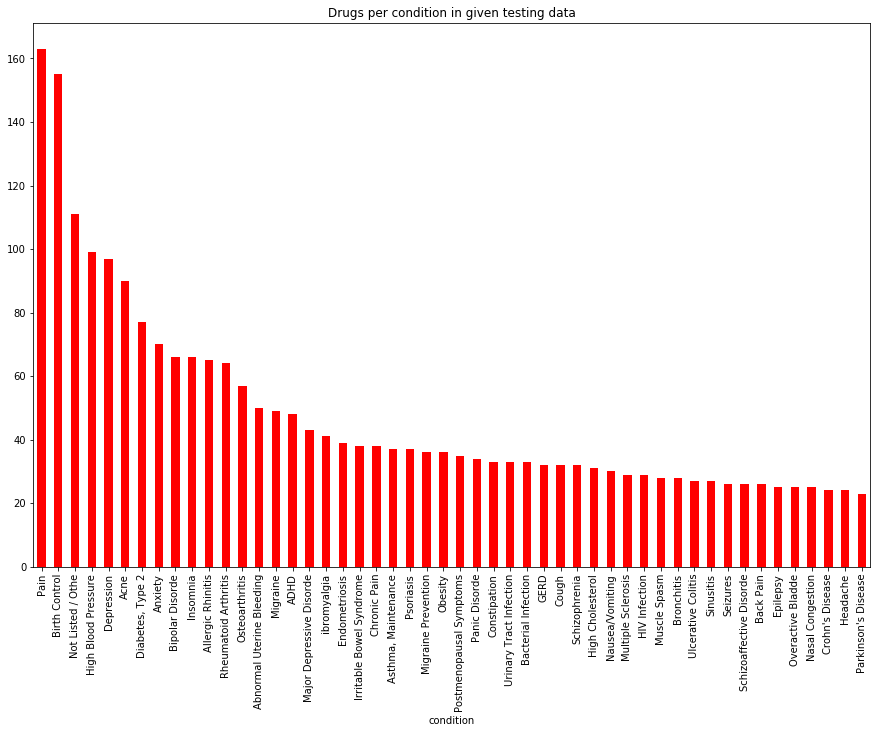

In [8]:
condition_drugName_test = test_data.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_drugName_test[0:50].plot(kind="bar", figsize = (15,10), color="red")
plt.title("Drugs per condition in given testing data")

In [9]:
def rate(x):
    if x > 5:
        return 1
    else:
        return 0

train_data['sentiment'] = train_data['rating'].apply(lambda x: rate(x))
test_data['sentiment'] = test_data['rating'].apply(lambda x: rate(x))

In [10]:
df_positive = train_data[train_data['sentiment']==1]
df_negative = train_data[train_data['sentiment']==0]

In [11]:
#some words often considered as stopwords are useful for our analysis
stopwords = nltk.corpus.stopwords.words('english')

not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stopwords.remove(i)

In [12]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in stopwords]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

In [13]:
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

In [14]:
#data pre-processing to clean our text data in order to extract features

stemmer = nltk.SnowballStemmer('english')
import re
from bs4 import BeautifulSoup

def review_to_words(raw_review):
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    words = letters_only.lower().split()
    meaningful_words = [w for w in words if not w in stopwords]
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    return( ' '.join(stemming_words))

In [15]:
df_positive['review_clean'] = df_positive['review'].apply(review_to_words)
df_negative['review_clean'] = df_negative['review'].apply(review_to_words)

C:\Users\ADMIN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ADMIN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
from collections import defaultdict
freq_dict = defaultdict(int)
for sent in df_negative["review_clean"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'red')

freq_dict = defaultdict(int)
for sent in df_positive["review_clean"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'green')

fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Trigrams of Negative sentiment", 
                                          "Trigrams of Positive sentiment"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1000, width=1200,paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

C:\Users\ADMIN\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [17]:
freq_dict = defaultdict(int)
for sent in df_negative["review_clean"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'red')

freq_dict = defaultdict(int)
for sent in df_positive["review_clean"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["4grams of Negative sentiment", 
                                          "4grams of Positive sentiment"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="4grams Count Plots")
py.iplot(fig, filename='word-plots')

In [18]:
train_data['review_clean'] = train_data['review'].apply(review_to_words)
test_data['review_clean'] = test_data['review'].apply(review_to_words)

In [19]:
x_train = train_data['review_clean']
x_test = test_data['review_clean']

In [20]:
y_train = train_data['sentiment']
y_test = test_data['sentiment']

In [21]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [22]:
vectorizer = TfidfVectorizer(analyzer='word', min_df=2, ngram_range=(4, 4), max_features = 25000)
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=25000,
                min_df=2, ngram_range=(4, 4), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [23]:
pipeline = Pipeline([('vect', vectorizer)])

In [24]:
%time train_data_features = pipeline.fit_transform(train_data['review_clean'])
%time test_data_features = pipeline.fit_transform(test_data['review_clean'])

Wall time: 37.3 s
Wall time: 14.5 s


In [25]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(1000, input_shape=(25000,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Dense(500, input_shape=(25000,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Dense(500))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Dense(250))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Dense(250))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              25001000  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000)              4000      
_________________________________________________________________
activation_1 (Activation)    (None, 1000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
_________________________________________________________________
activation_2 (Activation)    (None, 500)              

In [27]:
%time training_res = model.fit(train_data_features, y_train, epochs=10, batch_size=64, validation_split=0.2)

Train on 129037 samples, validate on 32260 samples
Epoch 1/10
129037/129037 [==============================] - 1393s 11ms/step - loss: 0.5731 - accuracy: 0.7199 - val_loss: 0.5362 - val_accuracy: 0.7427
Epoch 2/10
129037/129037 [==============================] - 1387s 11ms/step - loss: 0.4714 - accuracy: 0.7740 - val_loss: 0.5239 - val_accuracy: 0.7539
Epoch 3/10
129037/129037 [==============================] - 1388s 11ms/step - loss: 0.4211 - accuracy: 0.7960 - val_loss: 0.5312 - val_accuracy: 0.7565
Epoch 4/10
129037/129037 [==============================] - 1385s 11ms/step - loss: 0.3949 - accuracy: 0.8060 - val_loss: 0.5612 - val_accuracy: 0.7601
Epoch 5/10
129037/129037 [==============================] - 2751s 21ms/step - loss: 0.3805 - accuracy: 0.8117 - val_loss: 0.5791 - val_accuracy: 0.7619
Epoch 6/10
129037/129037 [==============================] - 2773s 21ms/step - loss: 0.3706 - accuracy: 0.8161 - val_loss: 0.5918 - val_accuracy: 0.7608
Epoch 7/10
129037/129037 [===========

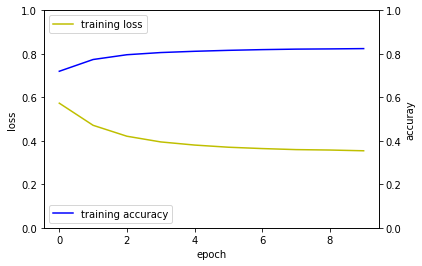

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(training_res.history['loss'], 'y', label='training loss')
acc_ax.plot(training_res.history['accuracy'], 'b', label='training accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [30]:
y_pred = model.predict(test_data_features)
y_pred = y_pred.round()
print('Classification Report: ')
labels = [0, 1]
print(classification_report(y_test, y_pred, labels=labels))

Classification Report: 
              precision    recall  f1-score   support

           0       0.29      0.15      0.20     16207
           1       0.70      0.84      0.76     37559

    accuracy                           0.63     53766
   macro avg       0.49      0.50      0.48     53766
weighted avg       0.57      0.63      0.59     53766

